### Installations

In [1]:
!pip3 install emoji --quiet
!python -m nltk.downloader all --quiet
!pip3 install gensim --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 7.2 MB/s eta 0:00:00
<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour


In [2]:
from tensorflow.keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply, Softmax
from tensorflow.keras.layers import RepeatVector, Dense, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model, Model
import tensorflow.keras.backend as K
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import random
import emoji
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
import sys
sys.path.append('/content/datasets')
sys.path.append('/content/util_functions')

from preprocessing_utils import *
from attention_map_utils import *

### Preprocessing Texts

In [4]:
X_train, Y_train, X_test, Y_test = prepare_train_and_test_sets('/content/datasets/train_emoji.csv',
                                                               '/content/datasets/test_emoji.csv')

In [5]:
max_len_of_sentence = 0
for sentence in X_train:
  if max_len_of_sentence < len(sentence.split()):
    max_len_of_sentence = len(sentence.split())

num_of_classes = max(Y_train) + 1
max_len_mask = 4

Freq of labels in trainset: 
0  :  40  :  0.202
1  :  40  :  0.202
2  :  39  :  0.197
3  :  38  :  0.192
4  :  41  :  0.207


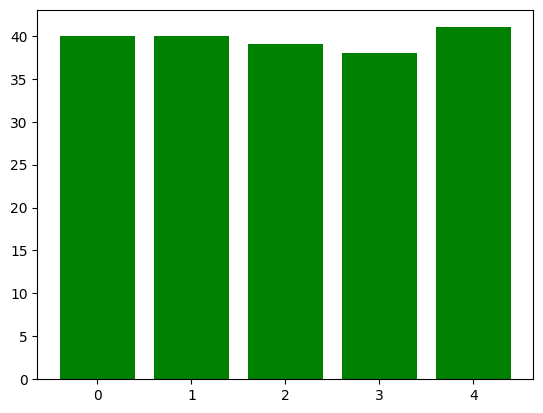

In [6]:
print("Freq of labels in trainset: ")
count_freq_labels(Y_train, num_of_classes)

# print("Freq of labels in testset: ")
# count_freq_labels(Y_test)

In [7]:
# X_train = lemmatize(X_train)
X_train = preprocess_corpus(X_train, max_len_mask)
X_test, X_test_intact = preprocess_corpus(X_test, max_len_mask, return_unprocessed = True)

In [8]:
print(X_train[:5])

['never talk never talk' 'proud achievement proud achievement'
 'worst day life worst' 'miss much miss much' 'food life food life']


In [9]:
frequent_words = dict()

for i in range(num_of_classes):
  frequent_words[i] = dict()

frequent_words = calc_most_freq_words(X_train, Y_train, frequent_words)
frequent_words = calc_most_freq_words(X_test, Y_test, frequent_words)
for i in range(num_of_classes):
  frequent_words[i] = sorted(frequent_words[i].items(), key=lambda x:x[1], reverse = True)

In [10]:
print("Love:\t\t", frequent_words[0])
print("Baseball:\t", frequent_words[1])
print("Smile:\t\t", frequent_words[2])
print("Sad:\t\t", frequent_words[3])
print("Food:\t\t", frequent_words[4])

Love:		 [('miss', 23), ('love', 18), ('cute', 12), ('dog', 7), ('lovely', 6), ('family', 6), ('much', 5), ('dear', 5), ('handsome', 5), ('valentine', 4), ('attractive', 3), ('lot', 3), ('kind', 3), ('date', 3), ('hug', 3), ('friend', 3), ('grandmother', 3), ('present', 3), ('upset', 3), ('mum', 2), ('baby', 2), ('dad', 2), ('person', 2), ('see', 2), ('good', 2), ('tonight', 2), ('dinner', 2), ('dearest', 1), ('adore', 1), ('two', 1), ('like', 1), ('puppy', 1), ('adorable', 1), ('friendly', 1), ('look', 1), ('want', 1), ('ever', 1), ('song', 1), ('best', 1), ('get', 1), ('give', 0), ('cutest', 0), ('man', 0), ('attracitve', 0), ('saw', 0), ('take', 0), ('break', 0), ('life', 0), ('day', 0), ('near', 0), ('valentin', 0), ('star', 0), ('back', 0)]
Baseball:	 [('ball', 15), ('baseball', 11), ('game', 8), ('player', 8), ('play', 6), ('run', 6), ('go', 5), ('exercise', 5), ('stadium', 5), ('many', 4), ('let', 4), ('favorite', 4), ('staduim', 4), ('match', 4), ('want', 3), ('chicago', 3), ('f

In [11]:
print("Frequency of sentences' lengths in X_train: ")
get_freq_count_len(X_train)

print("Frequency of sentences' lengths in X_test: ")
get_freq_count_len(X_test)

Frequency of sentences' lengths in X_train: 
4  :  198
Frequency of sentences' lengths in X_test: 
4  :  50


In [12]:
copy_of_X_train = X_train.copy()
copy_of_X_test = X_test.copy()
word2vec_input = np.append(copy_of_X_train, copy_of_X_test)

In [13]:
# word2vec_input = np.append(copy_of_X_train, copy_of_X_test)

In [13]:
# shuffling and duplicating sentences
X_train, Y_train = augment_sentences(X_train, Y_train, max_len_mask)

### Get Vocabulary

In [14]:
vocab_dict = get_vocab(X_train, X_test)

In [15]:
print(len(vocab_dict))

for word in vocab_dict.keys():
  print(word, " : ", vocab_dict[word])

# print(vocab_dict)

251
acceptance  :  0
achievement  :  1
adorable  :  2
adore  :  3
afternoon  :  4
algorithm  :  5
alone  :  6
always  :  7
amaze  :  8
announcement  :  9
answer  :  10
anything  :  11
approve  :  12
around  :  13
ask  :  14
assignment  :  15
attracitve  :  16
attractive  :  17
away  :  18
awesome  :  19
awful  :  20
baby  :  21
back  :  22
bad  :  23
ball  :  24
base  :  25
baseball  :  26
basketball  :  27
begin  :  28
best  :  29
birthday  :  30
boil  :  31
bore  :  32
bravo  :  33
break  :  34
breakfas  :  35
breakfast  :  36
brighten  :  37
bring  :  38
brunch  :  39
bullshit  :  40
bully  :  41
cake  :  42
candy  :  43
cannot  :  44
catcher  :  45
celebrate  :  46
charm  :  47
cheese  :  48
chicago  :  49
chinese  :  50
code  :  51
come  :  52
congrats  :  53
cook  :  54
cooky  :  55
could  :  56
cub  :  57
cute  :  58
cutest  :  59
dad  :  60
dance  :  61
dare  :  62
date  :  63
day  :  64
dear  :  65
dearest  :  66
dedication  :  67
deserve  :  68
dinner  :  69
disappoint  :  70

### Word2Vec Embedding

In [16]:
word2vec_embed_size = 100
word2vec = Word2Vec(vector_size = word2vec_embed_size, min_count = 1, window = 2, alpha = 0.01)

In [17]:
word2vec_input = list(word2vec_input[j].split() for j in range(len(word2vec_input)))

In [18]:
print(word2vec_input[29])

['let', 'brunch', 'day', 'let']


In [19]:
word2vec.build_vocab(word2vec_input, progress_per = 10000)

In [20]:
word2vec.train(word2vec_input, total_examples = word2vec.corpus_count, epochs = 90)

(56272, 89280)

In [21]:
print(word2vec.wv["love"].shape)
print(word2vec.wv.most_similar("miss"))

(100,)
[('work', 0.7079025506973267), ('dad', 0.7036094665527344), ('rice', 0.7025814652442932), ('great', 0.6887766718864441), ('bad', 0.6884526610374451), ('order', 0.6877837777137756), ('good', 0.6769456267356873), ('dare', 0.6767833828926086), ('match', 0.6758888363838196), ('cute', 0.6729342341423035)]


In [22]:
X_train_embedding = get_embedding_of_sentences(X_train, word2vec)

In [23]:
X_test_embedding = get_embedding_of_sentences(X_test, word2vec)

In [24]:
print(X_train_embedding.shape)
print(X_test_embedding.shape)
# Each sentence has 5 words, each word has 50 embedding size

(396, 4, 100)
(50, 4, 100)


### Model Architecture

In [25]:
repeator = RepeatVector(max_len_mask)
concatenator = Concatenate(axis=-1)
densor1 = Dense(10, activation = "tanh")
densor2 = Dense(1, activation = "relu")
activator = Softmax(axis = 1)
dotor = Dot(axes = 1)

In [26]:
def one_step_attention(a, s_prev):
    """
    Performs one step of attention: Outputs a context vector computed as a dot product of the attention weights
    "alphas" and the hidden states "a" of the Bi-LSTM.

    Arguments:
    a -- hidden state output of the Bi-LSTM, numpy-array of shape (m, Tx, 2*n_a)
    s_prev -- previous hidden state of the (post-attention) LSTM, numpy-array of shape (m, n_s)

    Returns:
    context -- context vector, input of the next (post-attention) LSTM cell
    """

    print("Prev state shape before being repeated: ", s_prev.shape)
    s_prev = repeator(s_prev)
    print("Prev state shape after being repeated: ", s_prev.shape)
    print("Current state shape: ", a.shape)
    concat = concatenator([a, s_prev])
    # Use densor1 to propagate concat through a small fully-connected neural network to compute the "intermediate energies" variable e. (≈1 lines)
    print("Before densor1 (concatentation of current and prev states): ", concat.shape)
    e = densor1(concat)
    print("After densor1: ", e.shape)
    energies = densor2(e)
    print("After densor2: ", energies.shape)
    # Use "activator" on "energies" to compute the attention weights "alphas" (≈ 1 line)
    alphas = activator(energies)
    print("Attention shape: ", alphas.shape)
    # Use dotor together with "alphas" and "a", in this order, to compute the context vector to be given to the next (post-attention) LSTM-cell (≈ 1 line)
    context = dotor([alphas, a])
    print("Attention dot curr shape: ", context.shape)

    return context, energies

In [27]:
n_a_ = 32 # number of units for the pre-attention, bi-directional LSTM's hidden state 'a'
n_s_ = 64 # number of units for the post-attention LSTM's hidden state "s"

post_activation_LSTM_cell = LSTM(n_s_, return_state = True)
output_layer = Dense(num_of_classes, activation="softmax")
# The softmax term should be in "", else, it gives error.

In [28]:

def modelf(Tx, Ty, n_a, n_s, word_embed_size):

    # Define the inputs of your model with a shape (Tx, human_vocab_size)
    # Define s0 (initial hidden state) and c0 (initial cell state)
    X = Input(shape=(Tx, word_embed_size))
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    preds = []
    attention_weights = []

    # Step 1: Define your pre-attention Bi-LSTM. (≈ 1 line)
    a = Bidirectional(LSTM(units = n_a, return_sequences = True))(X)

    # Step 2: Iterate for Ty steps
    for t in range(Ty):

        # Step 2.A: Perform one step of the attention mechanism to get back the context vector at step t (≈ 1 line)
        context, attention = one_step_attention(a, s)
        # Step 2.B: Apply the post-attention LSTM cell to the "context" vector. (≈ 1 line)
        # Don't forget to pass: initial_state = [hidden state, cell state]
        # Remember: s = hidden state, c = cell state
        _, s, c = post_activation_LSTM_cell(context, initial_state = [s, c])
        # Step 2.C: Apply Dense layer to the hidden state output of the post-attention LSTM (≈ 1 line)
        out = output_layer(s)
        # print("One output: ", out.shape)
        # Step 2.D: Append "out" to the "outputs" list (≈ 1 line)
        preds.append(out)
        attention_weights.append(attention)

    # Step 3: Create model instance taking three inputs and returning the list of outputs. (≈ 1 line)
    model = Model(inputs = [X, s0, c0], outputs = preds[-1])

    return model

In [29]:
model = modelf(Tx = max_len_mask, Ty = num_of_classes, n_a = n_a_, n_s = n_s_, word_embed_size = word2vec_embed_size)

Prev state shape before being repeated:  (None, 64)
Prev state shape after being repeated:  (None, 4, 64)
Current state shape:  (None, 4, 64)
Before densor1 (concatentation of current and prev states):  (None, 4, 128)
After densor1:  (None, 4, 10)
After densor2:  (None, 4, 1)
Attention shape:  (None, 4, 1)
Attention dot curr shape:  (None, 1, 64)
Prev state shape before being repeated:  (None, 64)
Prev state shape after being repeated:  (None, 4, 64)
Current state shape:  (None, 4, 64)
Before densor1 (concatentation of current and prev states):  (None, 4, 128)
After densor1:  (None, 4, 10)
After densor2:  (None, 4, 1)
Attention shape:  (None, 4, 1)
Attention dot curr shape:  (None, 1, 64)
Prev state shape before being repeated:  (None, 64)
Prev state shape after being repeated:  (None, 4, 64)
Current state shape:  (None, 4, 64)
Before densor1 (concatentation of current and prev states):  (None, 4, 128)
After densor1:  (None, 4, 10)
After densor2:  (None, 4, 1)
Attention shape:  (None, 

In [30]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 4, 100)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ s0 (InputLayer)           │ (None, 64)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 4, 64)          │         34,048 │ input_layer[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector             │ (None, 4, 64)          │              0 │ s0[0][0], lstm[0][1],  │
│ (RepeatVector)            │                        │                │ lstm[1][1],            │
│                           │                        │                │ lstm[2][1], lstm[3][1] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 4, 128)         │              0 │ bidirectional[0][0],   │
│                           │                        │                │ repeat_vector[0][0],   │
│                           │                        │                │ bidirectional[0][0],   │
│                           │                        │                │ repeat_vector[1][0],   │
│                           │                        │                │ bidirectional[0][0],   │
│                           │                        │                │ repeat_vector[2][0],   │
│                           │                        │                │ bidirectional[0][0],   │
│                           │                        │                │ repeat_vector[3][0],   │
│                           │                        │                │ bidirectional[0][0],   │
│                           │                        │                │ repeat_vector[4][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 4, 10)          │          1,290 │ concatenate[0][0],     │
│                           │                        │                │ concatenate[1][0],     │
│                           │                        │                │ concatenate[2][0],     │
│                           │                        │                │ concatenate[3][0],     │
│                           │                        │                │ concatenate[4][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 4, 1)           │             11 │ dense[0][0],           │
│                           │                        │                │ dense[1][0],           │
│                           │                        │                │ dense[2][0],           │
│                           │                        │                │ dense[3][0],           │
│                           │                        │                │ dense[4][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ softmax (Softmax)         │ (None, 4, 1)           │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0],         │
│                           │                        │                │ dense_1[2][0],         │
│                           │                        │                │ dense_1[3][0],         │
│                      

 Total params: 68,698 (268.35 KB)

 Trainable params: 68,698 (268.35 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
opt = Adam(learning_rate = 0.005, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [32]:
y_train_one_hot = to_categorical(Y_train, num_classes = num_of_classes)
y_test_one_hot = to_categorical(Y_test, num_classes = num_of_classes)
print(y_train_one_hot.shape)
print(y_test_one_hot.shape)

(396, 5)
(50, 5)


In [33]:
print(y_train_one_hot[13])
print(y_test_one_hot[13])

print(X_train_embedding.shape)

[1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]
(396, 4, 100)


### Model Traning

In [34]:
s0 = np.zeros((len(X_train), n_s_))
c0 = np.zeros((len(X_train), n_s_))

s0_t = np.zeros((len(X_test), n_s_))
c0_t = np.zeros((len(X_test), n_s_))


checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

history = model.fit(
    x = [X_train_embedding, s0, c0],
    # y = [y_train_one_hot, np.zeros((len(X_train_embedding), max_len_mask, 1))], # Dummy output to get attention weights and preds simultaneously
    y = y_train_one_hot,
    validation_data = ([X_test_embedding, s0_t, c0_t], y_test_one_hot),
          # validation_data = ([X_test_embedding, s0_t, c0_t], [y_test_one_hot, np.zeros((len(X_test_embedding), max_len_mask, 1))]),
    epochs=100,
    batch_size=50,
    verbose = 1,
    callbacks=[checkpoint]
    )

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 188ms/step - accuracy: 0.2020 - loss: 1.6106 - val_accuracy: 0.1600 - val_loss: 1.6257
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3085 - loss: 1.5989 - val_accuracy: 0.2600 - val_loss: 1.5974
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3399 - loss: 1.5668 - val_accuracy: 0.2400 - val_loss: 1.5268
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3469 - loss: 1.4113 - val_accuracy: 0.2800 - val_loss: 1.4537
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4543 - loss: 1.2070 - val_accuracy: 0.2600 - val_loss: 1.4143
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5186 - loss: 1.1214 - val_accuracy: 0.2800 - val_loss: 1.3682
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5971 - loss: 0.9531 - val_accuracy: 0.5000 - val_loss: 1.2282
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6229 - loss: 0.8609 - val_accuracy: 0.4800 - val_los

In [35]:
from tensorflow.keras.models import load_model
best_model = load_model('best_model.keras')

In [36]:
print(X_test_embedding.shape)

(50, 4, 100)


In [37]:
print(type(X_test_embedding))
print(X_test_embedding.shape)
print(best_model.input_shape)

<class 'numpy.ndarray'>
(50, 4, 100)
[(None, 4, 100), (None, 64), (None, 64)]


In [38]:
s0_test = np.zeros((X_test.shape[0], n_s_))
c0_test = np.zeros((X_test.shape[0], n_s_))

test_loss = best_model.evaluate([X_test_embedding, s0_test, c0_test], y_test_one_hot, batch_size=100)
print(f"Test Loss: {test_loss}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6400 - loss: 1.2233
Test Loss: [1.2233132123947144, 0.6399999856948853]


### Showing Samples from Test Set

In [39]:
s0_test = np.zeros((X_test.shape[0], n_s_))
c0_test = np.zeros((X_test.shape[0], n_s_))

preds = best_model.predict([X_test_embedding, s0_test, c0_test])

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 992ms/step


In [40]:
sample_sentences = []
sample_labels = []

pred_classes = np.argmax(preds, axis = -1)

for i in range(len(pred_classes)):
  if pred_classes[i] == Y_test[i]:
    sample_sentences.append(X_test_intact[i])
    sample_labels.append(pred_classes[i])

In [69]:
print_predictions(X = np.asarray(sample_sentences), pred = np.asarray(sample_labels))


i am upset	
Predicted emotion:  ❤️


we had such a lovely dinner tonight	
Predicted emotion:  ❤️


where is the food	
Predicted emotion:  🍴


stop making this joke ha ha ha	
Predicted emotion:  😄


where is the ball	
Predicted emotion:  ⚾


work is hard	
Predicted emotion:  😞


this girl is messing with me	
Predicted emotion:  😞


are you serious ha ha	
Predicted emotion:  😄


let us go play baseball	
Predicted emotion:  ⚾


this stupid grader is not working 	
Predicted emotion:  😞


stop messing around	
Predicted emotion:  😞


i love taking breaks	
Predicted emotion:  ❤️


you brighten my day	
Predicted emotion:  😄


why are you feeling bad	
Predicted emotion:  😞


my grandmother is the love of my life	
Predicted emotion:  ❤️


valentine day is near	
Predicted emotion:  ❤️


i miss you so much	
Predicted emotion:  ❤️


throw the ball	
Predicted emotion:  ⚾


my life is so boring	
Predicted emotion:  😞


she said yes	
Predicted emotion:  😄


dance with me	
Predicted emotion:  😄


i am

### Plotting Attention Weights

Attentions:  <KerasTensor shape=(None, 4, 1), dtype=float32, sparse=False, name=keras_tensor_544>
s0 and c0 shapes:  (1, 64) (1, 64)
sentence processed:  ['exam score awful disappoint']
Embedding shape:  (1, 4, 100)
attention weights shape:  (1, 4, 1)
attention weights (normalized):  tf.Tensor(
[[[0.9041541 ]
  [0.926707  ]
  [0.95679045]
  [1.        ]]], shape=(1, 4, 1), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Emoji:  😞


<Figure size 640x480 with 0 Axes>

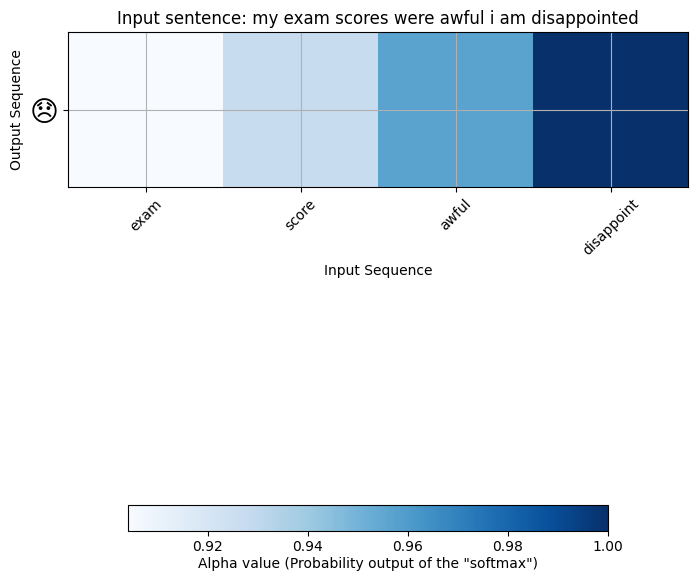

In [70]:
test_sentence = 'My exam scores were awful I am disappointed'
find_attetion_between_label_and_words(modelx = best_model, text = np.asarray([test_sentence.lower()]),
                                      Tx = max_len_mask, Ty = 1, embed_model = word2vec)

Attentions:  <KerasTensor shape=(None, 4, 1), dtype=float32, sparse=False, name=keras_tensor_704>
s0 and c0 shapes:  (1, 64) (1, 64)
sentence processed:  ['serious funny joke laugh']
Embedding shape:  (1, 4, 100)
attention weights shape:  (1, 4, 1)
attention weights (normalized):  tf.Tensor(
[[[0.7359699 ]
  [0.8334854 ]
  [0.90329546]
  [1.        ]]], shape=(1, 4, 1), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Emoji:  😄


<Figure size 640x480 with 0 Axes>

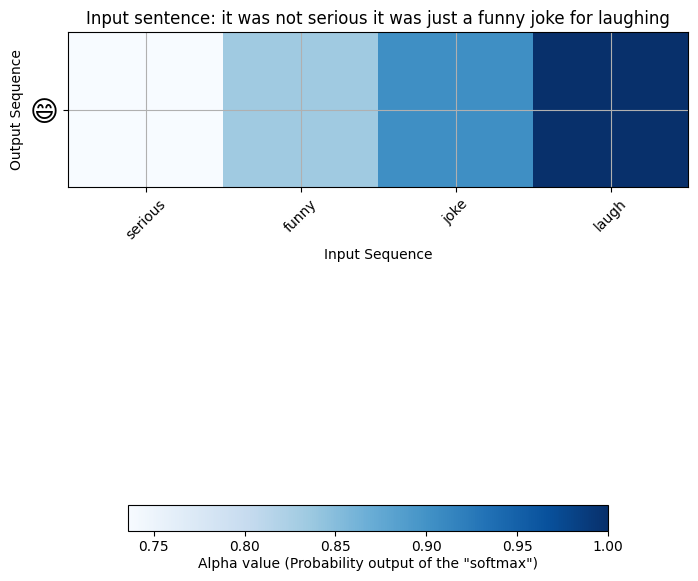

In [86]:
test_sentence = 'It was not serious It was just a funny joke for laughing'
find_attetion_between_label_and_words(modelx = best_model, text = np.asarray([test_sentence.lower()]),
                                      Tx = max_len_mask, Ty = 1, embed_model = word2vec)

Attentions:  <KerasTensor shape=(None, 4, 1), dtype=float32, sparse=False, name=keras_tensor_754>
s0 and c0 shapes:  (1, 64) (1, 64)
sentence processed:  ['eat vegetable pizza work']
Embedding shape:  (1, 4, 100)
attention weights shape:  (1, 4, 1)
attention weights (normalized):  tf.Tensor(
[[[1.        ]
  [0.9141764 ]
  [0.8689183 ]
  [0.80099934]]], shape=(1, 4, 1), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Emoji:  🍴


/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 127860 (\N{FORK AND KNIFE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127860 (\N{FORK AND KNIFE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


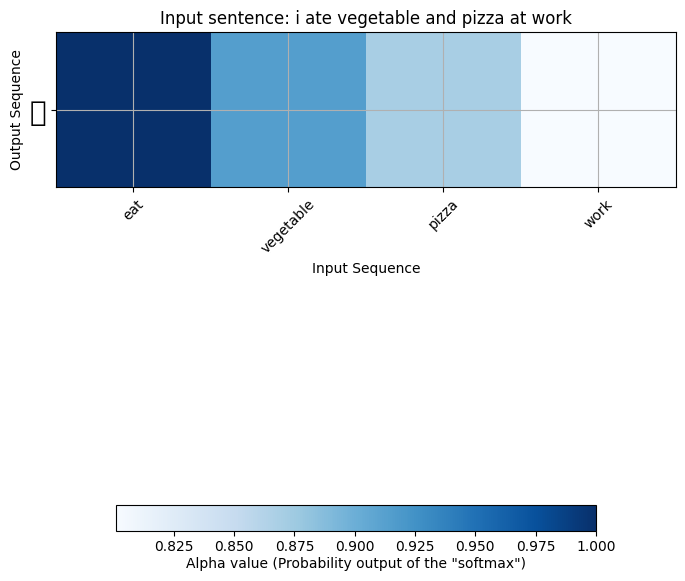

In [91]:
test_sentence = 'I ate vegetable and pizza at work'
find_attetion_between_label_and_words(modelx = best_model, text = np.asarray([test_sentence.lower()]),
                                      Tx = max_len_mask, Ty = 1, embed_model = word2vec)